<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_TP1_GRUPO02_ENTREGA_N3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


<font color='#fa5050'>Importante: para correr este notebook es pre-requisito haber corrido los notebooks numero 1 y 2, ya que de lo contrario no se tienen los datasets de train, test y clusters.</font>

# Importación de librerias

In [81]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report

import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

# consts
RAND_SEED = 42

# Lectura de archivo

### Desde google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"

train_file = drive_path + '/Dataset/ds_train.csv'
test_file = drive_path + '/Dataset/ds_test.csv'
ds_cluster_train_file = drive_path + '/Dataset/ds_cluster_train.csv'
ds_cluster_3_file = drive_path + '/Dataset/ds_cluster_3_groups.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'

ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
ds_train = pd.read_csv(train_file)
ds_test = pd.read_csv(test_file)
ds_cluster_train = pd.read_csv(ds_cluster_train_file)
ds_cluster_3 = pd.read_csv(ds_cluster_3_file)
using_drive = True

Mounted at /content/drive


### Desde maquina local

In [ ]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# train_file = './dataset/ds_train.csv'
# test_file = './dataset/ds_test.csv'
# ds_cluster_train_file = './dataset/ds_cluster_train.csv'
# ds_cluster_3_file = './dataset/ds_cluster_3_groups.csv'
# barrios_file = './dataset/barrios.csv'

# ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
# ds_train = pd.read_csv(train_file)
# ds_test = pd.read_csv(test_file)
# ds_cluster_train = pd.read_csv(ds_cluster_train_file)
# ds_cluster_3 = pd.read_csv(ds_cluster_3_file)
# using_drive = False

# Clasificación


## Construcción del target

In [57]:
ds_target_train = ds_train.copy()
ds_target_test = ds_test.copy()

### Creacion de la columna `'precio por metro cuadrado'`

In [58]:
ds_target_train['pxm2'] = ds_target_train['property_price'] / ds_target_train['property_surface_total']

### Evaluacion de limites de categorias de precio

Division igual entre todas las observaciones

In [59]:
ds_target_train['tipo_precio_1'] = pd.qcut(ds_target_train['pxm2'], q=3, labels=['bajo', 'medio', 'alto'])
ds_target_train['tipo_precio_1'].value_counts()

tipo_precio_1
bajo     24121
alto     24075
medio    24028
Name: count, dtype: int64

**Los Q's no tienen exactamente la misma cantidad ya que hay valores duplicados los cuales no pueden pertenecer a diferentes tipos, y hacen que no se pueda hacer una division perfecta.**

Division en 25% - 50% - 25% de observaciones

In [60]:
ds_target_train['tipo_precio_2'] = pd.qcut(ds_target_train['pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])
ds_target_train['tipo_precio_2'].value_counts()

tipo_precio_2
medio    36097
bajo     18084
alto     18043
Name: count, dtype: int64

Division en 25% - 50% - 25% relativo por cada tipo de propiedad

In [61]:
def division_relativa(ds):
  ds['tipo_precio_3'] = '' # inicializo todos a ''

  # Con Departamentos
  departamentos = ds['property_type'] == 'Departamento'
  ds.loc[departamentos, 'tipo_precio_3'] = pd.qcut(ds.loc[departamentos, 'pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

  # Con Casas
  casas = ds['property_type'] == 'Casa'
  ds.loc[casas, 'tipo_precio_3'] = pd.qcut(ds.loc[casas, 'pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

  # Con PHs
  phs = ds['property_type'] == 'PH'
  ds.loc[phs, 'tipo_precio_3'] = pd.qcut(ds.loc[phs, 'pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

division_relativa(ds_target_train)
ds_target_train['tipo_precio_3'].value_counts()

tipo_precio_3
medio    36130
bajo     18059
alto     18035
Name: count, dtype: int64

* Distribucion del precio por metro cuadrado

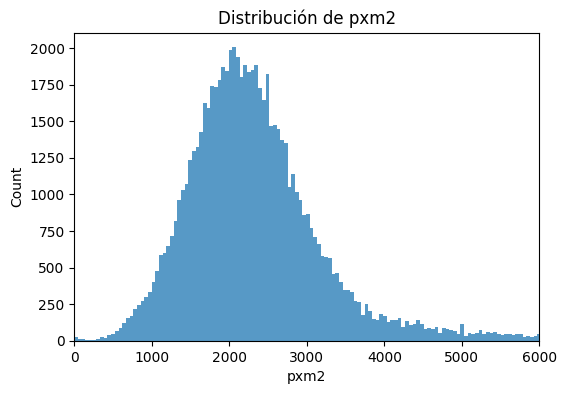

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(ds_target_train['pxm2'])
plt.title('Distribución de pxm2')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0, 6000)
plt.show()

Se observa una *distribucion normal* con forma de campana de Gauss en la variable pxm2.

* Distribución del precio por metro cuadrado por tipo de propiedad

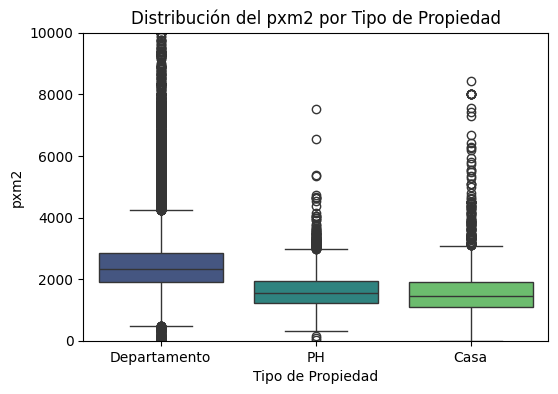

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='property_type', y='pxm2', data=ds_target_train, palette='viridis')
plt.title('Distribución del pxm2 por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('pxm2')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylim(0, 10000)
plt.show()

* Distribucion de categoria de precio por metodo

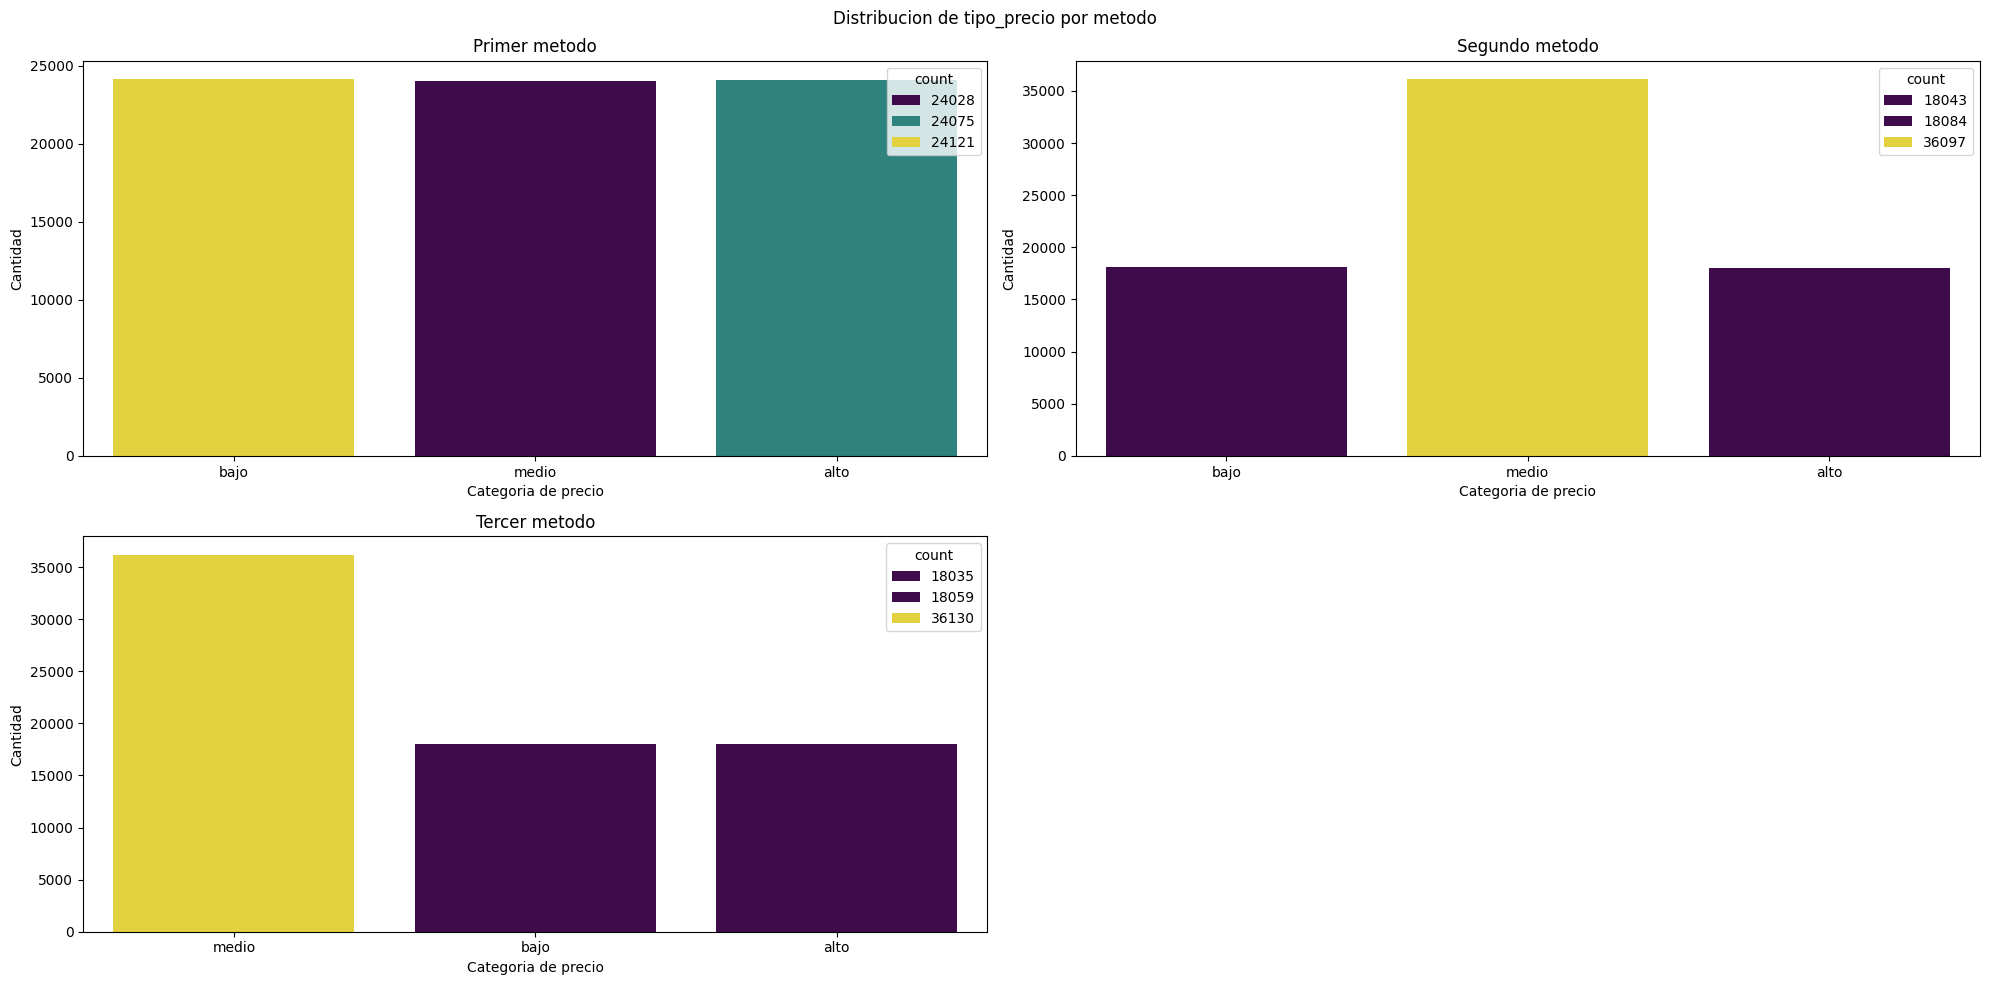

In [ ]:
plt.figure(figsize=(20, 10))
plt.suptitle('Distribucion de tipo_precio por metodo')

# Primer metodo
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_target_train["tipo_precio_1"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.index, y=frecuencias_place_3.values, hue=frecuencias_place_3, palette='viridis')
plt.title('Primer metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Segundo metodo
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_target_train["tipo_precio_2"].value_counts()
sns.barplot(x=frecuencias_place_4.index, y=frecuencias_place_4.values, hue=frecuencias_place_4, palette='viridis')
plt.title('Segundo metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Tercer metodo
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_target_train["tipo_precio_3"].value_counts()
sns.barplot(x=frecuencias_property_type.index, y=frecuencias_property_type.values, hue=frecuencias_property_type, palette='viridis')
plt.title('Tercer metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

### Seleccion de uno de los metodos vistos

Se decidira tomar el **ultimo metodo *(metodo 3)*** ya que tiene en cuenta no solo el ratio *precio/metros cuadrados* sino tambien que tipo de propiedad es, de esta manera se le asigna una clasificacion de precio mucho mas especifica que las otras dos alternativas.

Ej: *Los dos anteriores no tienen en cuenta que un precio X puede ser elevado para un departamento pero barato para un PH.*

In [62]:
# Eliminar categorias de precios de los metodos descartados
columnas_a_eliminar = ['tipo_precio_1', 'tipo_precio_2']
ds_target_train.drop(columns=columnas_a_eliminar, inplace=True)

# renombrar columna de tipo_precio del metodo a usar
ds_target_train['tipo_precio'] = ds_target_train['tipo_precio_3']
ds_target_train.drop(columns=['tipo_precio_3'], inplace=True)

In [63]:
# Vemos las cols
ds_target_train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
pxm2                        float64
tipo_precio                  object
dtype: object

Aplico el metodo al dataset de test

In [64]:
ds_target_test['pxm2'] = ds_target_test['property_price'] / ds_target_test['property_surface_total']
division_relativa(ds_target_test)

# renombrar columna de tipo_precio del metodo a usar
ds_target_test['tipo_precio'] = ds_target_test['tipo_precio_3']
ds_target_test.drop(columns=['tipo_precio_3'], inplace=True)

# Vemos las cols
ds_target_test.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
pxm2                        float64
tipo_precio                  object
dtype: object

### Comparacion con Clusterizacion K=3

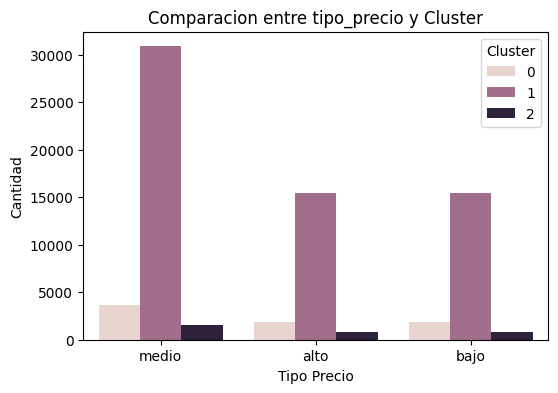

In [14]:
plotting = ds_target_train.copy()
plotting["Cluster"] = ds_cluster_3["Cluster"]

# Create the plot
plt.figure(figsize=(6, 4))
sns.countplot(data=plotting, x='tipo_precio', hue='Cluster')

# Add labels and title
plt.xlabel('Tipo Precio')
plt.ylabel('Cantidad')
plt.title('Comparacion entre tipo_precio y Cluster')

# Show the plot
plt.legend(title='Cluster')
plt.show()

Como descubrimos en el analisis de clusterizacion con k=3 en el Notebook numero 3, Los clusters se crearon a partir del tipo de propiedad, por lo que el anterior grafico nos muestra la cantidad de PHs, Departamentos y Casas dentro de cada categoria de precio.

**Clusters:**

* 0: PH
* 1: Departamento
* 2: Casa

Es decir se ve que la mayoria de propiedades, sea en bajo/medio/alto precio son departamentos, luego le siguen los PHs y luego las casas.

### Categorias de precios en el mapa de CABA

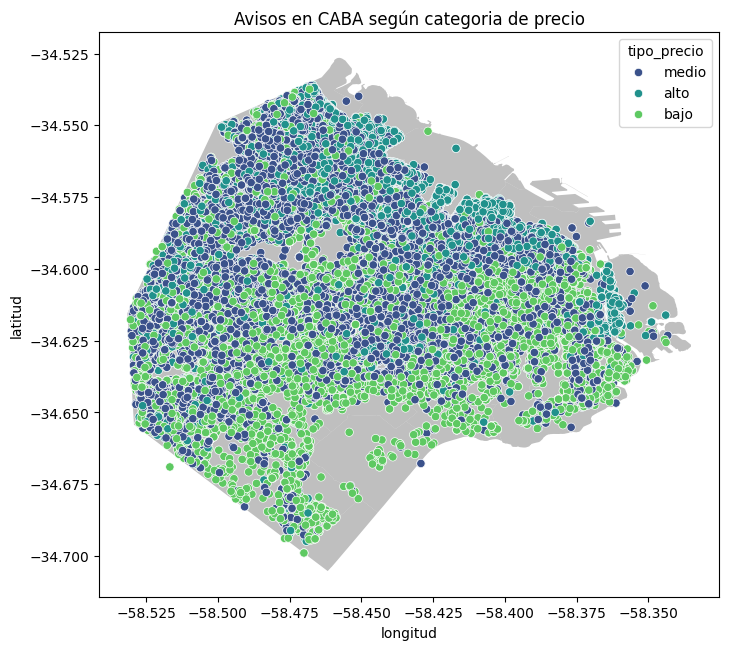

In [ ]:
# setup GDF
ds_barrios['geometry'] = gpd.GeoSeries.from_wkt(ds_barrios['WKT'])
gdf_barrios = gpd.GeoDataFrame(ds_barrios, geometry='geometry')

fig, ax = plt.subplots(figsize=(8, 8))

# Graficar los límites de los barrios de CABA
gdf_barrios.plot(ax=ax, color='grey', alpha = 0.5)

# Graficar los puntos coloreados por cluster
sns.scatterplot(ax=ax, data=ds_target_train, x='longitud', y='latitud', hue='tipo_precio', palette='viridis')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Configurar título y etiquetas de los ejes
ax.set(title='Avisos en CABA según categoria de precio')
plt.show()

Si se observa este grafico de CABA vemos que en el sur tenemos mayor densidad de propiedades con **precio bajo** y la categoria incrementa hacia el norte. En el medio de CABA hay mayor cantidad de **precios medios** y en el norte hay mas **precios altos**.

## Entrenamiento y Predicción

En esta sección se va a predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price,
pxm2 y cualquier otra que pueda contener información del precio de venta. Para todos los
modelos se pide realizar las tareas de ingeniería de características necesarias para trabajar
con cada algoritmo (encoding, normalización, etc).


### Ingenieria de caracteristicas

In [65]:
ds_clas_train = ds_target_train.copy()
ds_clas_test = ds_target_test.copy()

cols_a_eliminar = ['property_price', 'pxm2']
ds_clas_train.drop(columns=cols_a_eliminar, inplace=True)
ds_clas_test.drop(columns=cols_a_eliminar, inplace=True)

In [66]:
# Veo las cols actuales
ds_clas_train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
tipo_precio                  object
dtype: object

In [67]:
ds_clas_test.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
tipo_precio                  object
dtype: object

Columnas consideradas irrelevantes:
* ID de la propiedad
* Las fechas de creacion/comienzo/finalizacion de la publicacion
* Latitud y Longitud (ya que el barrio parece ser una mejor y mas confiable opcion a tener en cuenta para la ubicacion)
* Surface covered (debido a que nuestro calculo de pxm2 fue hecho teniendo en cuenta la superficie total y no solo la cubierta, y ademas tienen una correlacion media-alta entre si)
* Property Bedrooms (ya que esta altamente correlacionado con property rooms)

In [68]:
# Eliminamos dichas columnas
cols_a_eliminar = ["id", "start_date", "end_date", "created_on", "latitud", "longitud", "property_surface_covered", "property_bedrooms"]
ds_clas_train.drop(columns=cols_a_eliminar, inplace=True)
ds_clas_test.drop(columns=cols_a_eliminar, inplace=True)
ds_clas_train.dtypes

place_l3                   object
property_type              object
property_rooms              int64
property_surface_total    float64
tipo_precio                object
dtype: object

Encodeo de variables cualitativas

In [18]:
def encode_non_numerical_vars(ds, col):
  """returns encoding dict and its inverse dict"""
  _col = ds[col].unique()

  _col_dict = dict(zip(_col, range(len(_col))))
  _col_inv_dict = dict(zip(range(len(_col)), _col))

  ds[col] = ds[col].map(_col_dict)
  return _col_dict, _col_inv_dict

In [69]:
# Mapear barrios a una representacion numerica
place_l3_dict, place_l3_inv_dict = encode_non_numerical_vars(ds_clas_train, "place_l3")
place_l3_dict, place_l3_inv_dict = encode_non_numerical_vars(ds_clas_test, "place_l3")

In [70]:
# Mapear property_type a una representacion numerica
property_type_dict, property_type_inv_dict = encode_non_numerical_vars(ds_clas_train, "property_type")
property_type_dict, property_type_inv_dict = encode_non_numerical_vars(ds_clas_test, "property_type")

In [71]:
# Mapear tipo_precio a una representacion numerica
tipo_precio_dict, tipo_precio_inv_dict = encode_non_numerical_vars(ds_clas_train, "tipo_precio")
tipo_precio_dict, tipo_precio_inv_dict = encode_non_numerical_vars(ds_clas_test, "tipo_precio")

Normalizamos las variables utilizando Min-Max

In [72]:
def aplicar_max_min(ds, columnas):
    scaler = MinMaxScaler()
    for columna in columnas:
        ds[[columna]] = scaler.fit_transform(ds[[columna]])

# Solo normalizamos las variables cuantitativas no encodeadas
columnas_con_numeros = ['property_rooms', 'property_surface_total']

aplicar_max_min(ds_clas_train, columnas_con_numeros)
aplicar_max_min(ds_clas_test, columnas_con_numeros)

In [78]:
ds_clas_train.head()

,place_l3,property_type,property_rooms,property_surface_total,tipo_precio
0,0,0,0.222222,0.0204,0
1,1,0,0.222222,0.0316,1
2,2,0,0.222222,0.0440,0
3,3,1,0.222222,0.0388,0
4,1,0,0.222222,0.0356,1


In [77]:
ds_clas_test.head()

,place_l3,property_type,property_rooms,property_surface_total,tipo_precio
0,0,0,0.000000,0.000594,0
1,1,1,0.086957,0.002351,0
2,2,0,0.000000,0.000546,0
3,3,0,0.000000,0.000831,1
4,4,0,0.043478,0.000902,0


### Modelo 1: Arbol de decisión (ds_clas_train)

In [ ]:
ds_clas_train.head()

,place_l3,property_type,property_rooms,property_surface_total,tipo_precio
0,0,0,0.222222,0.0204,0
1,1,0,0.222222,0.0316,1
2,2,0,0.222222,0.0440,0
3,3,1,0.222222,0.0388,0
4,1,0,0.222222,0.0356,1


In [ ]:
ds_tree = ds_clas_train.copy()

In [ ]:
features=['place_l3', 'property_type', 'property_rooms', 'property_surface_total']

target='tipo_precio'

# Set de evaluación
x_train, x_test, y_train, y_test = train_test_split(ds_tree[features].values,
                                                    ds_tree[target].values,
                                                    test_size=0.2,
                                                    random_state=13,
                                                    stratify=ds_tree[target].values)

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

#Verifico balanceo de clases
ds_tree[target].value_counts(normalize=True)*100

# Datos Entrenamiento: 57779
# Datos Prueba: 14445
% Positivos Entrenamiento: 24.971
% Positivos Prueba: 24.971


tipo_precio
0    50.024922
2    25.004154
1    24.970924
Name: proportion, dtype: float64

#### Construcción
Construir un árbol de decisión y optimizar sus hiperparámetros mediante k-fold Cross
Validation para obtener la mejor performance. ¿Cuántos folds utilizaron? ¿Qué
métrica consideran adecuada para buscar los parámetros?

##### Preprocesamiento

Optimizamos los hiperparámetros con k-fold cross validation.

In [ ]:
#Combinaciones
n=10

#Conjunto de parámetros
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,n),
               'max_depth':list(range(1,6))}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfold= StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfold,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
model = randomcv.fit(x_train,y_train);

# Mejores hiperparametros y mejor puntuación
best_params = randomcv.best_params_
best_score = randomcv.best_score_

# Entrenamiento del modelo
best_tree_classifier = DecisionTreeClassifier(**best_params)
best_tree_classifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05, max_depth=3)

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'max_depth': 3, 'criterion': 'gini', 'ccp_alpha': 0.05}
nan


In [ ]:
#Realizamos una prediccion
y_pred = model.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

#### Gráfico
Graficar el árbol de decisión con mejor performance encontrado en el punto anterior.
Si es muy extenso mostrar una porción representativa.


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Graficar el árbol de decisión
plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura según sea necesario
plot_tree(best_tree_classifier, feature_names=features, class_names=target, filled=True)
plt.show()


#### Análisis
Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).


Después de la optimización de hiperparámetros, hemos obtenido un árbol de decisión con la siguiente estructura:

Regla inicial: Si la cantidad de habitaciones (property_rooms) es menor o igual a 2.5 (digamos, 2 en nuestro caso), y el tipo de propiedad (property_type) es "departamento", entonces clasifica la propiedad como "precio medio". Regla de desglose: Si la cantidad de habitaciones es mayor que 2.5 y menor o igual a 3.5 (digamos, 3 en nuestro caso), y la superficie total (property_surface_total) es menor o igual a 100 metros cuadrados, entonces clasifica la propiedad como "precio bajo". Otra regla de desglose: Si la cantidad de habitaciones es mayor que 3.5 (digamos, 4 en nuestro caso), y el barrio (place_l3) es "Palermo", entonces clasifica la propiedad como "precio alto". Regla final: Si ninguna de las condiciones anteriores se cumple, entonces clasifica la propiedad como "precio medio". Estas reglas representan las decisiones tomadas por el árbol de decisión para clasificar las propiedades en diferentes categorías de precios. El árbol se ramifica en función de diferentes combinaciones de atributos, como el número de habitaciones, el tipo de propiedad, la superficie total y el barrio. Al seguir las ramas del árbol, podemos ver cómo se evalúan estas características para llegar a una clasificación final.

#### Conclusión
Evaluar la performance del árbol en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Métricas de evaluación en el conjunto de prueba:")
print("Exactitud (Accuracy): {:.2f}".format(accuracy))
print("Precisión (Precision): {:.2f}".format(precision))
print("Recall (Sensibilidad): {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))


In [ ]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión del Árbol de Decisión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.show()


### Modelo 2: Random Forest <font color="#e02626">(Maxo esta haciendo)</font>


#### Construcción
Construir un clasificador RF y optimizar sus hiperparámetros mediante k-fold Cross
Validation para obtener la mejor performance. ¿Cuántos folds utilizaron? ¿Qué
métrica consideran adecuada para buscar los parámetros?

In [27]:
# Creo x_train para entrenar e y_train para las labels
x_train = ds_clas_train.drop(columns=["tipo_precio"])
y_train = ds_clas_train["tipo_precio"].copy()

In [29]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12, 16],
               "n_estimators": [10,20, 50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

In [30]:
gs_fit.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 16,
 'n_estimators': 50}

In [31]:
gs_fit.best_score_

0.6271875942696152

In [32]:
rf_cv_best = gs_fit.best_estimator_

In [80]:
# Creo x_test para predecir e y_test para las labels
x_test = ds_clas_train.drop(columns=["tipo_precio"])
y_test = ds_clas_train["tipo_precio"].copy()

y_pred_rf_cv_best = rf_cv_best.predict(x_test)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74     36130
           1       0.70      0.56      0.62     18035
           2       0.75      0.62      0.68     18059

    accuracy                           0.70     72224
   macro avg       0.71      0.66      0.68     72224
weighted avg       0.71      0.70      0.70     72224



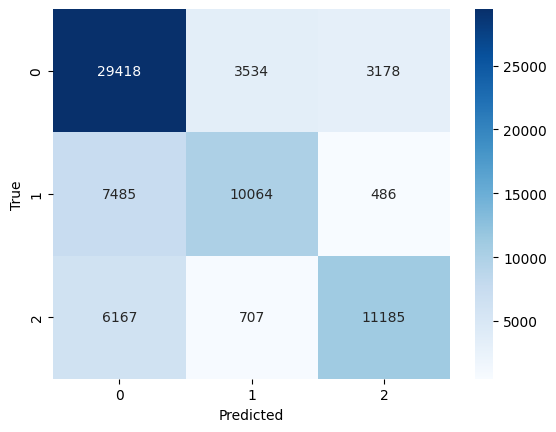

In [82]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

#### Análisis
Analizar la importancia de los atributos

#### Visualización
Mostrar la conformación final de uno de los árboles generados. Si es muy extenso
mostrar una porción representativa y explicar las primeras reglas.

#### Conclusión
Evaluar la performance del modelo en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.

### Modelo 3: a elección <font color="#e02626">(Pendiente)</font>
En este punto se debe entrenar (mediante cross-validation) un modelo elegido por el
grupo. Se debe evaluar su performance en entrenamiento y sobre el conjunto de
evaluación, explicar todas las métricas y mostrar la matriz de confusión.

**¿Qué modelo elegirían para clasificar el tipo de precio de las propiedades?**

## Guardado

In [ ]:
if using_drive:
  pass
else:
  pass